In [ ]:
# Imports
import pandas as pd
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt

# Filepaths

# Leads to where the original parquet train and test is located
DATA_DIR = "YOURFILEPATH"

# Leads to where you would like to output the notebook
OUTPUT_DIR = "YOURFILEPATH"

In [2]:
# Train/Test/Validation Splits
train_parquet = f"{DATA_DIR}/train.parquet"
test_parquet = f"{DATA_DIR}/test.parquet"

train_csv = f"{DATA_DIR}/train.csv"
test_csv = f"{DATA_DIR}/test.csv"

channel_names = [f"channel_{x}" for x in range(41, 47)]  # channels 41-46
train_cols = ["id"] + channel_names + ["is_anomaly"]

# Reduction of size & Parquet to CSV
print("Reducing train set...")
train_df = pd.read_parquet(train_parquet, columns=train_cols)
train_df.to_csv(train_csv, index=False)
print("Reduced train shape:", train_df.shape)

print("Reducing test set...")
test_df = pd.read_parquet(test_parquet, columns=["id"] + channel_names)
test_df.to_csv(test_csv, index=False)
print("Reduced test shape:", test_df.shape)

# Train-Test and Validation Split
train_data, val_data = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    shuffle=False
)

print("Train subset shape:", train_data.shape)
print("Validation subset shape:", val_data.shape)

Reducing train set...
Reduced train shape: (14728321, 8)
Reducing test set...
Reduced test shape: (521280, 7)
Train subset shape: (12519072, 8)
Validation subset shape: (2209249, 8)


In [3]:
# Fit the iForest Model
contamination = train_data["is_anomaly"].sum() / len(train_data)
print("Estimated contamination:", contamination)

iforest = IForest(contamination=contamination, random_state=42)
iforest.fit(train_data[channel_names].values)

Estimated contamination: 0.10432993755447688


IForest(behaviour='old', bootstrap=False,
    contamination=np.float64(0.10432993755447688), max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

Validation Precision: 0.1932, Recall: 0.2414, F0.5: 0.2013


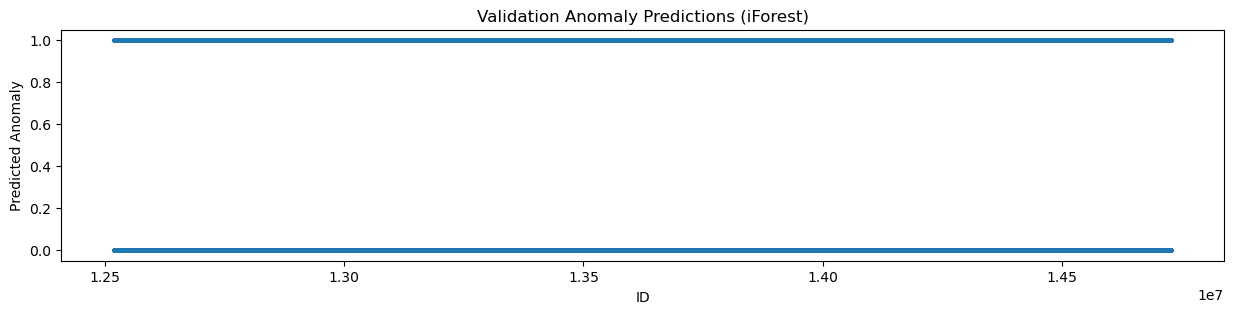

In [4]:
# Evaluate on the Validation Set
val_preds = iforest.predict(val_data[channel_names].values)

precision = precision_score(val_data["is_anomaly"], val_preds)
recall = recall_score(val_data["is_anomaly"], val_preds)
f05 = fbeta_score(val_data["is_anomaly"], val_preds, beta=0.5)
print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F0.5: {f05:.4f}")

# Plot validation detections
plt.figure(figsize=(15,3))
plt.plot(val_data["id"], val_preds, marker='o', linestyle='None', markersize=2)
plt.title("Validation Anomaly Predictions (iForest)")
plt.xlabel("ID")
plt.ylabel("Predicted Anomaly")
plt.show()


Submission file saved at: /users/yaseminates/Desktop/Work/01_Google_DSC/COPY-ESA-Spacecraft-Anomaly-Challenge/COPY-BenchmarkAlgorithms/submission.csv


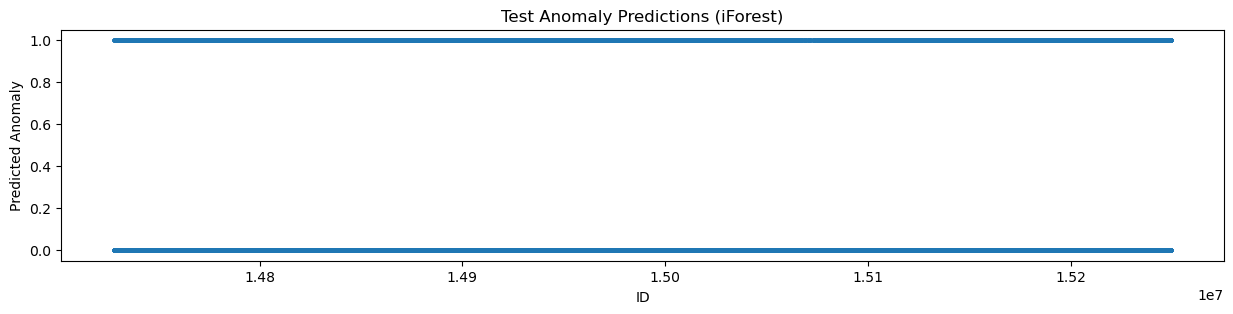

In [5]:
# Predict on the Test Set
detections = iforest.predict(test_df[channel_names].values)

submission_df = pd.DataFrame({
    "id": test_df["id"],
    "is_anomaly": detections
})

# Save the CSVs
submission_path = f"{OUTPUT_DIR}/submission.csv"
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved at: {submission_path}")

# Plot test detections
plt.figure(figsize=(15,3))
plt.plot(test_df["id"], detections, marker='o', linestyle='None', markersize=2)
plt.title("Test Anomaly Predictions (iForest)")
plt.xlabel("ID")
plt.ylabel("Predicted Anomaly")
plt.show()

<Axes: title={'center': 'Test Anomaly Predictions (iForest)'}, xlabel='id'>

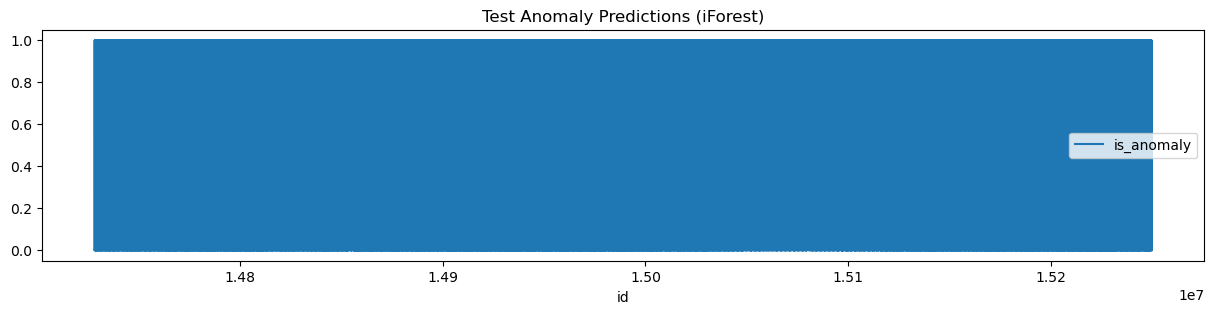

In [6]:
# Kaggle Plot
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "is_anomaly": detections
})

# Kaggle-style plot
submission_df.plot(x="id", y="is_anomaly", figsize=(15,3), title="Test Anomaly Predictions (iForest)")